In [257]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
import pprint as pp
import seaborn as sns
import pandas as pd

### Fitting By Hand

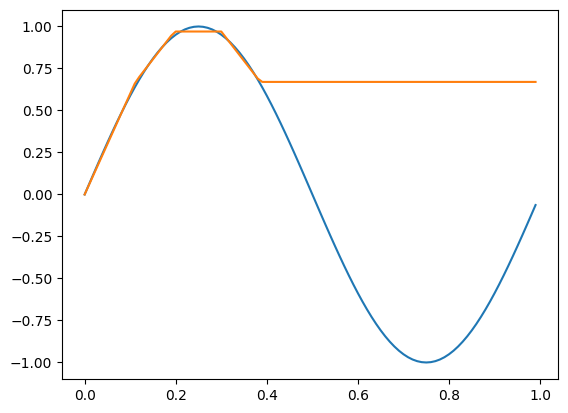

In [258]:
x = np.arange(0, 1, 0.01)
y = np.sin(2 * np.pi *x)

def relu(x): return np.maximum(x, 0)

# first layer
w1 = np.array([6, 3.5, -3.5, -6, 0, 0, 0, 0])
b1 = np.array([0, -0.42, 1.35, 1, 0, 0, 0, 0])

# second layer
w2 = np.array([-1, -1, -1, -1, 0, 0, 0, 0])
b2 = np.array([0.7, 0.27, 0.3, 0, 0, 0, 0, 1])

# output neuron
out = np.array([-1, -1, -1, -1, 0, 0, 0, 0.97])

# forward through the linear layers given input x
# implemented as a one-to-many loop
def forward(x):
    l1 = relu((x * w1 + b1))
    l2 = relu((w2 * l1 + b2))
    return l2 @ out.T

# # for visualization
def plot_nn():
    outputs = np.array([forward(i) for i in x])
    sns.lineplot(x=x, y=y)
    sns.lineplot(x=x, y=outputs)
    plt.show();

plot_nn()

### Numpy Model

In [259]:
def sigmoid(x): return 1 / (1 + np.exp(-x))

class SineNet:
    def __init__(self, X, y, activation):
        self.X, self.y = X, y
        self.activation = activation
        self.iters = 0

        def init():
            # return np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
            return np.random.random(size=8).reshape(1, -1)
            # return np.random.standard_normal(size=8).reshape(1, -1)

        self.w1 = init()                   # (1, 8)
        self.w2 = init()                   # (1, 8)
        self.b1 = init()                   # (1, 8)
        self.b2 = init()                   # (1, 8)

        self.head = init().reshape(-1, 1)  # (8, 1) - output layer

    def act(self, x):
        if self.activation == 'relu':
            return relu(x)
        else:
            return sigmoid(x)

    def training_pass(self, lr = 0.01):
        x = self.X.reshape(-1, 1)
        y = self.y.reshape(-1, 1)
        N = x.shape[0]  # X.shape = (N, 1)

        # forward
        h1 = (x @ self.w1 + self.b1)    # (N, 8)
        l1 = self.act(h1)                   # (N, 8)
        h2 = (self.w2 * l1 + self.b2)   # (N, 8)
        l2 = self.act(h2)                   # (N, 8)

        pred = l2 @ self.head           # (N, 1)

        loss = np.sum((pred - y)**2) / (2 * N)

        # partial derivatives
        dloss = (pred - y) / N                  # (N, 1)
        dl2 = dloss @ self.head.T               # (N, 8)
        dhead = l2.T @ dloss                    # (8, 1)

        if self.activation == 'relu':
            dh2 = dl2.copy()                    # (N, 8)
            dh2[h2 < 0] = 0                     # derivative through relu
        else:
            dh2 = l2 * (1 - l2) * dl2           # derivative through sigmoid

        dw2 = (l1 * dh2).sum(0, keepdims=True)  # (1, 8) -- sum bc broadcasting
        dl1 = self.w2 * dh2                     # (N, 8)
        db2 = dh2.sum(0, keepdims=True)         # (1, 8) -- sum bc broadcasting

        if self.activation == 'relu':
            dh1 = dl1.copy()                    # (N, 8)
            dh1[h1 < 0] = 0                     # derivative through relu
        else:
            dh1 = l1 * (1 - l1) * dl1           # derivative through sigmoid

        dx = dh1 @ self.w1.T                    # (N, 1)
        dw1 = x.T @ dh1                         # (1, 8)
        db1 = dh1.sum(0, keepdims=True)         # (1, 8) -- sum bc broadcasting

        # print(f"loss: {loss}, dloss: {dloss}")
        # print(f"dloss: {dloss}, dl2: {dl2}, dh2: {dh2}, dl1: {dl1}, dh1: {dh1}\n")
        # print(f"dhead: {dhead}, dw2: {dw2}, db2: {db2}, dw1: {dw1}, db1: {db1}\n")

        # print(np.max(h1))
        # print(l1)
        # print(h2)
        # print(l2)
        # print('h2:', h2)
        # print('dh2:', )

        # parameter updates
        self.head -= lr * dhead
        self.w2 -= lr * dw2
        self.b2 -= lr * db2
        self.w1 -= lr * dw1
        self.b1 -= lr * db1

        self.iters += 1

        return loss

    def get_params(self):
        print('w1')
        pp.pprint(self.w1)
        print('b1')
        pp.pprint(self.b1)
        print('w2')
        pp.pprint(self.w2)
        print('b2')
        pp.pprint(self.b2)
        print('head')
        pp.pprint(self.head)


    def forward(self, x):
        h1 = x * self.w1 + self.b1
        l1 = self.act(h1)
        h2 = l1 * self.w2 + self.b2
        l2 = self.act(h2)
        return l2 @ self.head

    def loss(self, y, x):
        return (y - self.forward(x))**2

    # for visualization
    def plot_nn(self):
        outputs = self.forward(self.X.reshape(-1, 1))
        sns.lineplot(x=self.X, y=self.y)
        sns.lineplot(x=self.X, y=outputs.reshape(-1))
        plt.title(f"Activation: {self.activation}, Iterations: {self.iters}")
        plt.show();

In [260]:
mod = SineNet(x, y, 'sigmoid')

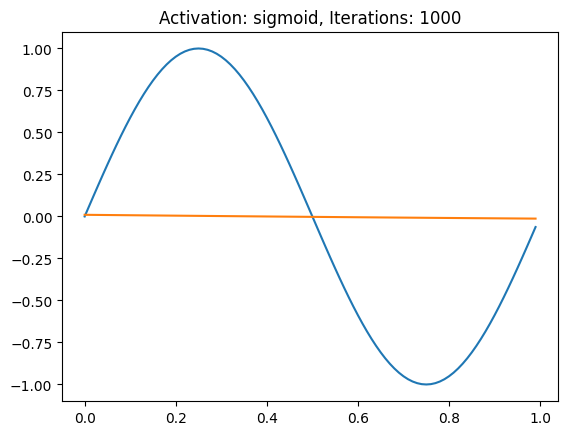

In [261]:
losses = []
epochs = 10
steps = 100
for epoch in range(epochs):
    for step in range(steps):
        l = mod.training_pass(lr=0.1)
        losses.append(l)

mod.plot_nn()

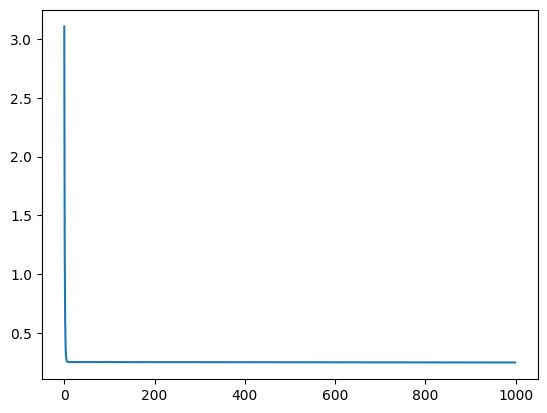

In [262]:
plt.plot(losses);

In [263]:
mod2 = SineNet(x, y, 'relu')

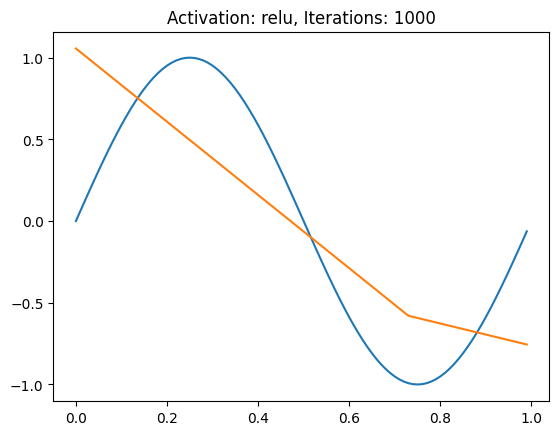

In [264]:
losses = []
epochs = 10
steps = 100
for epoch in range(epochs):
    for step in range(steps):
        l = mod2.training_pass(lr=0.1)
        losses.append(l)

mod2.plot_nn()

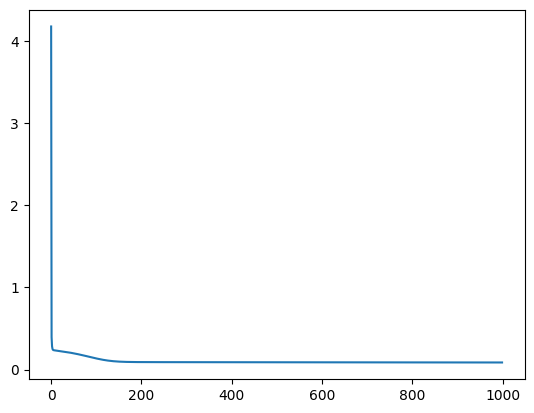

In [265]:
plt.plot(losses);

There's clearly still something weird witht the relu activation.......

### Pytorch Model

In [266]:
x = torch.tensor(x).float().view(-1, 1)
y = torch.tensor(y).float().view(-1, 1)

print(len(x), len(y))

100 100


In [267]:
class TorchNet(nn.Module):
    def __init__(self, activation, size: int = 8, scale: float = 1) -> None:
        super().__init__()
        self.h1 = nn.Linear(1, size)

        self.h2 = nn.Parameter(torch.randn(1, size) / scale)
        self.b2 = nn.Parameter(torch.randn(size) / scale)
        # self.h2 = nn.Linear(8, 8)
        self.head = nn.Linear(size, 1)
        self.loss =  nn.MSELoss()
        self.losses = []
        self.activation = activation
        self.iters = 0

    def forward(self, x, y):
        if self.activation == 'sigmoid':
            l1 = F.sigmoid(self.h1(x))
            l2 = F.sigmoid(l1 * self.h2 + self.b2)
        else:
            l1 = F.relu(self.h1(x))
            #l1 = self.h1(x)
            l2 = F.relu(l1 * self.h2 + self.b2)

        res = self.head(l2)
        return res, self.loss(res, y)

    def train(self, x, y, lr, steps=100, batch_size=10):
        for step in range(steps):
          # Naive batching
          for batch_ind in range(batch_size, len(x) + batch_size, batch_size):
              pred, loss = self.forward(x=x[batch_ind - batch_size:batch_ind], y=y[batch_ind - batch_size:batch_ind])

              self.losses.append(loss)

              # get gradients
              for p in self.parameters():
                  p.grad = None

              loss.backward()

              # update
              for p in self.parameters():
                  p.data -= lr * p.grad

        self.iters += steps

    def plot_nn(self, x, y):
        with torch.no_grad():
            p, l = self.forward(x, y)
        x = np.array(x).reshape(-1)
        y = np.array(y).reshape(-1)
        sns.lineplot(x=x, y=y)
        sns.lineplot(x=x, y=np.array(p).reshape(-1))
        plt.title(f"Activation: {self.activation}, Iterations: {self.iters}")
        plt.show();

In [268]:
mod3 = TorchNet(activation = 'relu', size = 32)

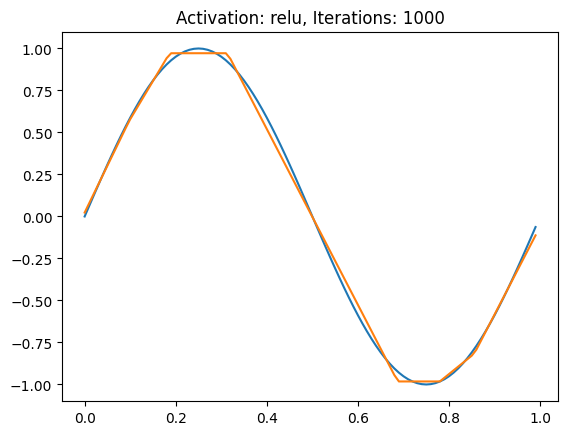

In [256]:
mod3 = TorchNet(activation = 'relu', size = 16, scale=10)
mod3.train(x, y, lr=0.1, steps=1000, batch_size=10)
mod3.plot_nn(x, y)

In [269]:
mod4 = TorchNet(activation='sigmoid', size = 6)

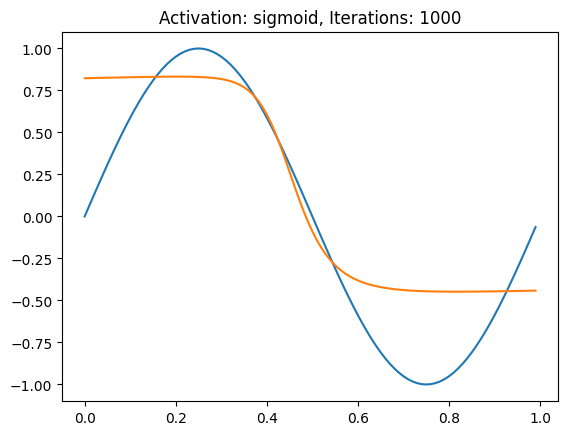

In [270]:
mod4.train(x, y, lr=0.2, steps=1000, batch_size=10)
mod4.plot_nn(x, y)

Again, something is not working with relu.....